In [32]:
TWITTER_USER = "ericsson"
NUM_OF_TWEETS = 30000
READ_FROM_CSV = False # Change here to read from .csv instead

# The exported .csv with 

## Extract

In [3]:
# from https://medium.com/better-programming/how-to-scrape-tweets-with-snscrape-90124ed006af
import snscrape.modules.twitter as sntwitter
import pandas as pd


In [2]:
# Pulling data from twitter takes approx. 2 minutes for 30000 tweets

if !READ_FROM_CSV:
    # Creating list to append tweet data to
    tweets_list_w_metadata = []

    # Using TwitterSearchScraper to scrape data and append tweets to list
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper('from:'+TWITTER_USER).get_items()):
        if i>NUM_OF_TWEETS:
            break
        tweets_list_w_metadata.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.outlinks, tweet.tcooutlinks, tweet.replyCount, tweet.retweetCount, tweet.likeCount, tweet.quoteCount, tweet.conversationId, tweet.media, tweet.retweetedTweet, tweet.quoteCount, tweet.mentionedUsers])
        
    # Creating a dataframe from the tweets list above 
    tweets_list_w_metadata = pd.DataFrame(tweets_list_w_metadata, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Outlinks', 'tcoutlinks', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount', 'conversationId', 'media', 'retweetedTweet', 'quoteCount', 'mentionedUsers'])

    # Display first 5 entries from dataframe
    tweets_list_w_metadata.head()

    # EXPORT TO CSV FIRST. Excel has all sorts of fallacies. For example numbers longer than 15 digits (Tweed Id and conversationId) get truncated
    tweets_list_w_metadata.to_csv("out-tweets-list-w-metadata-csv-ground-truth.csv", sep="ß", index=False) # using "ß" as Seperator as Excel can handle that on import

## Alternatively: Read from CSV file

In [5]:
if READ_FROM_CSV:
    tweets_list_w_metadata = pd.read_csv("out-tweets-list-w-metadata-csv-ground-truth.csv", sep="ß")
    tweets_list_w_metadata.head(2)

,Datetime,Tweet Id,Text,Username,Outlinks,tcoutlinks,replyCount,retweetCount,likeCount,quoteCount,conversationId,media,retweetedTweet,quoteCount.1,mentionedUsers
0,2021-02-24 01:00:19+00:00,1364379597513625606,"Emilio Romeo, MD of Ericsson ANZ, speaks with ...",ericsson,['http://m.eric.sn/Ges250DBnHj'],['https://t.co/TprAnEvbMh'],0,0,3,0,1364379597513625606,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,NaN,0,"[User(username='NBNCo', displayname='NBN Austr..."
1,2021-02-23 17:01:50+00:00,1364259182065709061,Sharing #streaming and voice calls 🤔 all at on...,ericsson,['http://m.eric.sn/a34M50DDKyR'],['https://t.co/rMOdOUoqxL'],0,2,16,0,1364259182065709061,[Photo(previewUrl='https://pbs.twimg.com/media...,NaN,0,NaN


## Transform

In [8]:
tweets_df1 = tweets_list_w_metadata.copy()

# Remove timezone from columns
tweets_df1['Datetime'] = tweets_df1['Datetime'].dt.tz_localize(None)

# Convert Tweet Id and conversationId to strings (Excel can't handle numbers longer than 15 digtis)
tweets_df1["Tweet Id"]= tweets_df1["Tweet Id"].map(str)
tweets_df1["conversationId"]= tweets_df1["conversationId"].map(str)

print(tweets_df1.dtypes)
print("\nshape dataframe: ", tweets_df1.shape)

Datetime           object
Tweet Id            int64
Text               object
Username           object
Outlinks           object
tcoutlinks         object
replyCount          int64
retweetCount        int64
likeCount           int64
quoteCount          int64
conversationId      int64
media              object
retweetedTweet    float64
quoteCount.1        int64
mentionedUsers     object
dtype: object

shape dataframe:  (20407, 15)


In [9]:
# Display first 3 entries from dataframe
tweets_df1.head(3)

,Datetime,Tweet Id,Text,Username,Outlinks,tcoutlinks,replyCount,retweetCount,likeCount,quoteCount,conversationId,media,retweetedTweet,quoteCount,mentionedUsers
0,2021-02-24 01:00:19,1364379597513625606,"Emilio Romeo, MD of Ericsson ANZ, speaks with ...",ericsson,[http://m.eric.sn/Ges250DBnHj],[https://t.co/TprAnEvbMh],0,0,3,0,1364379597513625606,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,None,0,[https://twitter.com/NBNCo]
1,2021-02-23 17:01:50,1364259182065709061,Sharing #streaming and voice calls 🤔 all at on...,ericsson,[http://m.eric.sn/a34M50DDKyR],[https://t.co/rMOdOUoqxL],0,2,16,0,1364259182065709061,[Photo(previewUrl='https://pbs.twimg.com/media...,None,0,None
2,2021-02-23 12:00:08,1364183255591829506,#FunFact 🎾 #Tennis and #5G have much more in ...,ericsson,[http://m.eric.sn/SwCE50DCltd],[https://t.co/UZ189Co7cT],0,2,9,0,1364183255591829506,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,None,0,None


In [ ]:
# Export to excel
tweets_df1.to_excel('out-tweets-with-metadata-excel.xlsx')
print("tweets_df1 exported as .xlsx Excel file")

## Word Count Analysis

In [1]:
# 

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import nltk
from nltk.corpus import stopwords
import regex as re
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [11]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())


def find_hashtags(txt):
    # trying this regular expression (regex) https://regexr.com/3h2rr
    return ["#" + x for x in re.findall("[\s\W]#(\w+)", txt)]

In [12]:
# Testing my Hashtag Regex Function
print(find_hashtags("hel #lo,#la #le"))

['#lo', '#la', '#le']


In [13]:
all_tweets = list(tweets_df1["Text"])
all_tweets[:3]

['Emilio Romeo, MD of Ericsson ANZ, speaks with Gavin Williams, CDO (Regional and Remote) at @NBNCo, on connecting remote communities, paving the way for better #education and #healthcare.\n\nDiscover more 🇦🇺 https://t.co/TprAnEvbMh\n\n#Ericsson130AU https://t.co/1EATkeMNrE',
 'Sharing #streaming and voice calls 🤔 all at once?\n\nWith WebRTC technology,\u202fwe are developing brand new voice services like #5G interactive calling. \n\nCheck it out 👀 \nhttps://t.co/rMOdOUoqxL https://t.co/wLBPMNkkrt',
 '#FunFact 🎾 #Tennis  and #5G have much more in common than you might think! \n\nGet our 3 key concepts needed for a perfect ‘game, set, match’ over your competitors 👇\n\n🔗 https://t.co/UZ189Co7cT https://t.co/oMpEp5ZTBR']

In [14]:
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]
all_tweets_no_urls[:3]

['Emilio Romeo MD of Ericsson ANZ speaks with Gavin Williams CDO Regional and Remote at NBNCo on connecting remote communities paving the way for better education and healthcareDiscover more Ericsson130AU',
 'Sharing streaming and voice calls all at onceWith WebRTC technologywe are developing brand new voice services like 5G interactive calling Check it out',
 'FunFact Tennis and 5G have much more in common than you might think Get our 3 key concepts needed for a perfect game set match over your competitors']

In [15]:
# Create a list of lists containing lowercase words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]
words_in_tweet[:1]

[['emilio',
  'romeo',
  'md',
  'of',
  'ericsson',
  'anz',
  'speaks',
  'with',
  'gavin',
  'williams',
  'cdo',
  'regional',
  'and',
  'remote',
  'at',
  'nbnco',
  'on',
  'connecting',
  'remote',
  'communities',
  'paving',
  'the',
  'way',
  'for',
  'better',
  'education',
  'and',
  'healthcarediscover',
  'more',
  'ericsson130au']]

## Most Common Words

In [16]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(15)

[('the', 15101),
 ('to', 10488),
 ('of', 7241),
 ('in', 6802),
 ('and', 6395),
 ('a', 5196),
 ('our', 4937),
 ('for', 4769),
 ('5g', 4436),
 ('is', 4289),
 ('ericsson', 4077),
 ('you', 3621),
 ('how', 3520),
 ('on', 3483),
 ('we', 3402)]

## Removing Common Words

In [17]:
# remove stopwords (e.g. "the", "a", "and")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# View a few words from the set
print("\nThe following stop words are removed:\n\n", stop_words, "\n\n")


The following stop words are removed:

 {'didn', 'isn', 'between', 'while', 'my', 'being', 'him', 'through', 'haven', 'me', 'myself', 'are', 'off', "it's", 'ourselves', 'ma', 'at', "should've", 'any', 'than', 'he', 'mustn', 'below', 'nor', "mustn't", 'hadn', 'under', "she's", 'and', 'hasn', 'but', "don't", 'with', "wasn't", 'why', 'had', 'same', 'who', 'i', 'been', 'themselves', 'about', 'few', 'm', "isn't", 'they', 'from', "you've", 'you', 'were', 'aren', 'd', 'theirs', 'before', 'again', 'not', 'own', 'of', 'more', 'she', 'once', 'for', "you'd", 'what', 'does', 'an', 'over', 'too', 'further', 's', 'did', 'll', 'down', 'shan', "haven't", 'because', 'against', 'ours', 'by', 'so', 'them', 're', 'won', 'am', 'the', 'yours', 'or', 'where', 've', 'yourself', 'its', 't', 'his', "that'll", 'no', 'into', 'above', 'her', 'ain', 'has', 'other', 'these', 'in', 'we', 'having', 'to', "hasn't", "won't", 'was', 'doing', 'himself', 'mightn', 'whom', 'herself', 'a', 'couldn', 'just', "you'll", 'both'

In [18]:
# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]


print("\nBefore removal:")
print(words_in_tweet[0])

print("\nAfter removal:")
print(tweets_nsw[0])


Before removal:
['emilio', 'romeo', 'md', 'of', 'ericsson', 'anz', 'speaks', 'with', 'gavin', 'williams', 'cdo', 'regional', 'and', 'remote', 'at', 'nbnco', 'on', 'connecting', 'remote', 'communities', 'paving', 'the', 'way', 'for', 'better', 'education', 'and', 'healthcarediscover', 'more', 'ericsson130au']

After removal:
['emilio', 'romeo', 'md', 'ericsson', 'anz', 'speaks', 'gavin', 'williams', 'cdo', 'regional', 'remote', 'nbnco', 'connecting', 'remote', 'communities', 'paving', 'way', 'better', 'education', 'healthcarediscover', 'ericsson130au']


## Counting Words

In [19]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('5g', 4436),
 ('ericsson', 4077),
 ('new', 2059),
 ('amp', 1697),
 ('mobile', 1483),
 ('learn', 1299),
 ('iot', 1285),
 ('future', 1254),
 ('network', 1227),
 ('read', 1104),
 ('technology', 1009),
 ('us', 997),
 ('check', 972),
 ('latest', 891),
 ('networks', 844)]

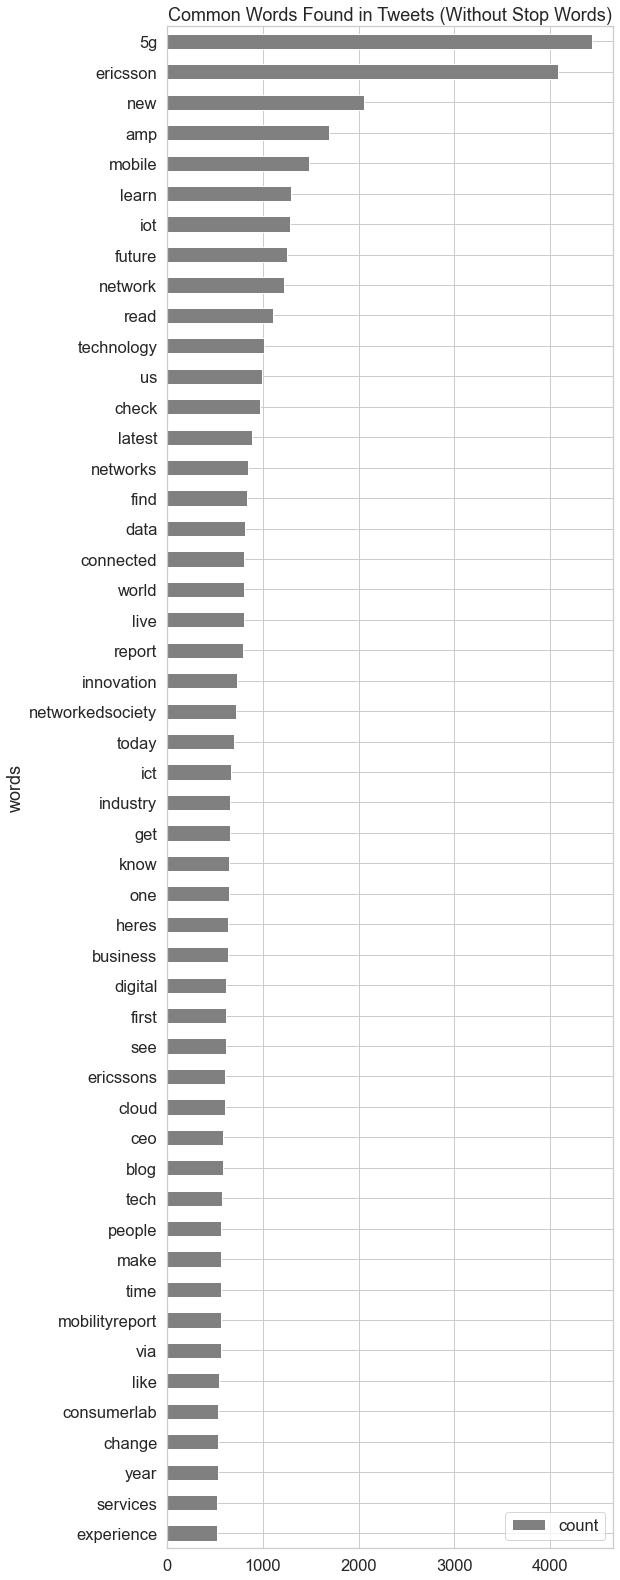

In [30]:
counts_nsw_df2 = pd.DataFrame(counts_nsw.most_common(50),
                             columns=['words', 'count'])

counts_nsw_df2.to_csv("out-word-count-top50.csv", sep=",", index=False) # using "," as seperator again

fig, ax = plt.subplots(figsize=(8, 28))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="grey")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.savefig('out-word-count-top50.png', bbox_inches='tight')
plt.show()


## Counting Hashtag Frequency

In [25]:

all_hashtags = [find_hashtags(tweet) for tweet in all_tweets]
print(all_hashtags[:3])

all_hashtags = list(itertools.chain(*all_hashtags))
counts_hashtags = collections.Counter(all_hashtags)
counts_hashtags.most_common(15)

[['#education', '#healthcare', '#Ericsson130AU'], ['#streaming', '#5G'], ['#Tennis', '#5G']]


[('#5G', 2849),
 ('#IoT', 1038),
 ('#MobilityReport', 500),
 ('#AI', 384),
 ('#ConsumerLab', 365),
 ('#networkedsociety', 351),
 ('#MWC19', 331),
 ('#NetworkedSociety', 331),
 ('#ICT', 249),
 ('#cloud', 215),
 ('#Ericsson', 214),
 ('#5GThings', 203),
 ('#VR', 189),
 ('#LTE', 149),
 ('#TV', 145)]

In [28]:
counts_hashtags_df3 = pd.DataFrame(counts_hashtags.most_common(50),
                             columns=['words', 'count'])

counts_hashtags_df3.to_csv("out-hashtag-count-top50.csv", sep=",", index=False) # using "," as seperator again

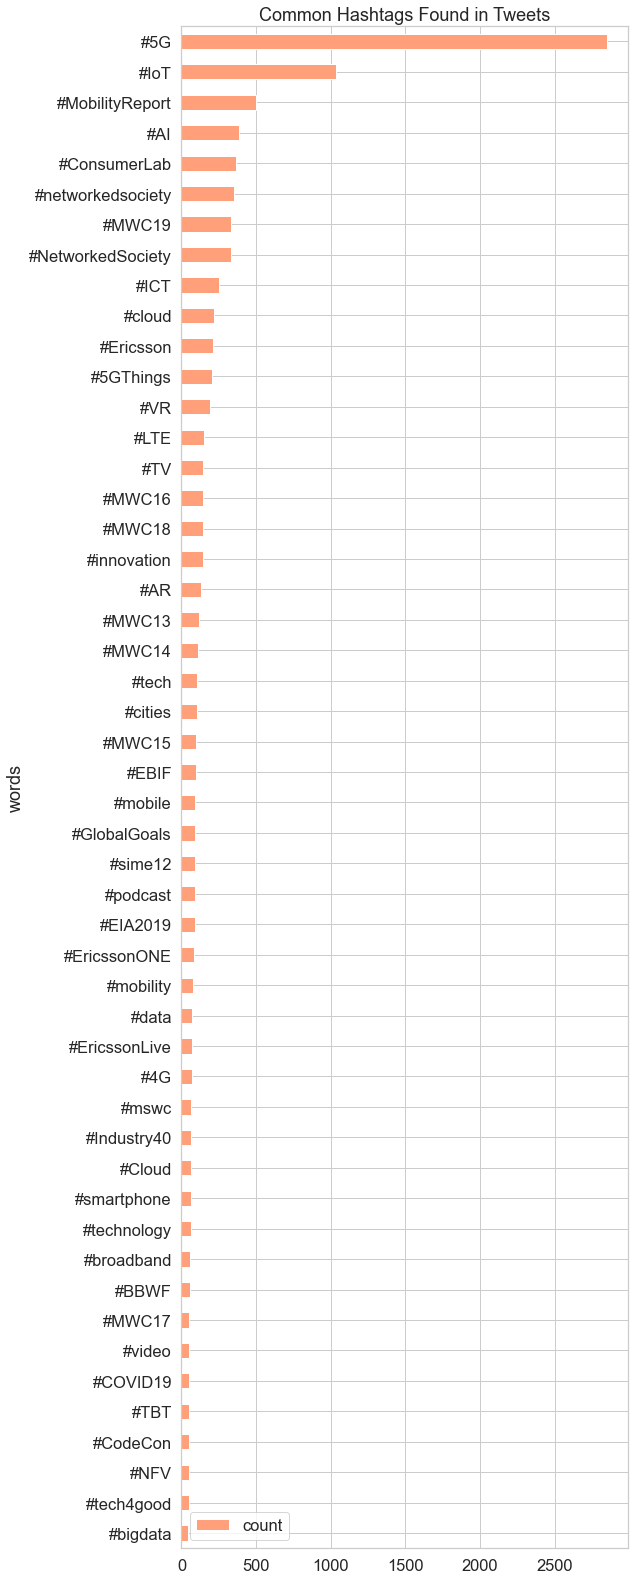

In [31]:
fig, ax = plt.subplots(figsize=(8, 28))

# Plot horizontal bar graph
counts_hashtags_df3.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="lightsalmon")

ax.set_title("Common Hashtags Found in Tweets")

plt.savefig('out-hashtag-count-top50.png', bbox_inches='tight')
plt.show()